In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import tensorflow.keras.backend as K

import argparse
import cv2
import albumentations as A

import os
import glob

In [2]:
patch_size = 37
channels = 1
img_shape = (patch_size,patch_size,channels)
sigma = 15

train_data_dir = 'datasets/Train400'
transform_RandomCrop = A.Compose([
    A.RandomCrop (width=patch_size,height = patch_size,always_apply=True),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.RandomRotate90()
])
transform = A.Compose([
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.RandomRotate90()
])

In [3]:
filenames = glob.glob(train_data_dir+'/'+'*.png')

img = cv2.imread(filenames[0], 1 if channels>1 else 0)
patches = np.expand_dims(transform_RandomCrop(image=img)['image'],axis=0)

for filename in filenames:
    img = cv2.imread(filename, 1 if channels>1 else 0)
    # if channels == 1:
    #     np.expand_dims(img,axis=3)
    w = img.shape[0]//patch_size
    h = img.shape[1]//patch_size
    for i in range(w):
        for j in range(h):
            patch = img[patch_size * i:patch_size *(i+1),patch_size *j:patch_size *(j+1)]
            patch = np.expand_dims(patch, axis=0)
            patches = np.concatenate((patches,patch), axis=0)

    # for _ in range(w*h):
    #     patch = transform_RandomCrop(image=img)['images']
    #     patch = np.expand_dims(patch,axis=0)
    #     patches = np.concatenate((patches,patch), axis=0)



In [4]:
preprocessing = transform(image=patches)

In [5]:
noise=np.random.normal(0,sigma,np.shape(preprocessing['image']))

x_train = preprocessing['image'] + noise
y_train = noise

x_train = x_train/255.0
y_train = y_train/255.0

if channels == 1:
    x_train = np.expand_dims(x_train,axis=3)
    y_train = np.expand_dims(y_train,axis=3)

In [6]:
def DnCNN():
    model = Sequential()

    model.add(Conv2D(64,kernel_size=(3,3),padding='same',input_shape = img_shape))
    model.add(Activation('relu'))

    for _ in range(14):
        model.add(Conv2D(64,kernel_size=(3,3),padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

    model.add(Conv2D(channels, kernel_size=(3,3),padding='same'))
    return model

In [10]:
model = DnCNN()
model.compile(optimizer=Adam(),loss='mean_squared_error')
model.fit(x_train,y_train,batch_size=128,epochs=50,verbose=1)

68/300
51/51 [==============================] - 40s 781ms/step - loss: 53.4858
Epoch 69/300
51/51 [==============================] - 40s 781ms/step - loss: 53.0584
Epoch 70/300
51/51 [==============================] - 40s 781ms/step - loss: 52.9974
Epoch 71/300
51/51 [==============================] - 40s 781ms/step - loss: 52.9695
Epoch 72/300
51/51 [==============================] - 40s 781ms/step - loss: 52.8903
Epoch 73/300
51/51 [==============================] - 40s 781ms/step - loss: 52.5048
Epoch 74/300
51/51 [==============================] - 40s 781ms/step - loss: 52.8799
Epoch 75/300
51/51 [==============================] - 40s 781ms/step - loss: 52.3524
Epoch 76/300
51/51 [==============================] - 40s 781ms/step - loss: 52.3616
Epoch 77/300
51/51 [==============================] - 40s 781ms/step - loss: 52.4461
Epoch 78/300
51/51 [==============================] - 40s 781ms/step - loss: 52.3591
Epoch 79/300
51/51 [==============================] - 40s 781ms/step - 

In [43]:
test_data_dir = 'datasets/BSD68'

In [44]:
filenames = glob.glob(test_data_dir+'/'+'*.png')
psnrs = 0
for filename in filenames:
    img = cv2.imread(filename, 1 if channels>1 else 0)
    img = np.expand_dims(img, axis = 0)
    if channels == 1:
        img = np.expand_dims(img, axis = 3)
    x_test = img
    y_test = np.random.normal(0, sigma, np.shape(img))
    
    x_test = x_test/255.0
    y_test = y_test/255.0

    y_pred = model.predict(x_test+y_test)
    result = x_test + y_test - y_pred

    x_test = np.clip(x_test,0,1)

    psnr = tf.image.psnr(result[0],img[0] ,  255)
    psnrs = psnrs + psnr
print(f"{test_data_dir.split('/')[-1]} Average PSNR : {psnrs/len(filenames)}")

BSD68 Average PSNR : 26.802412033081055


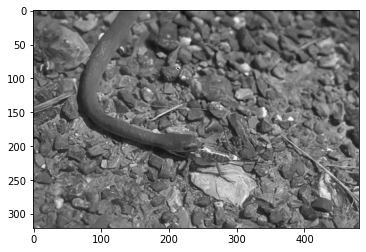

In [45]:
plt.imshow(result[0].astype(np.uint8),cmap='gray')

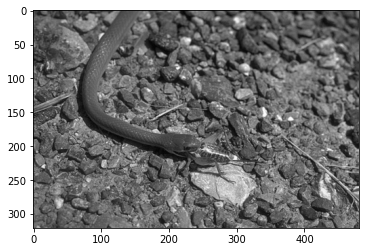

In [46]:
plt.imshow(img[0],cmap='gray')

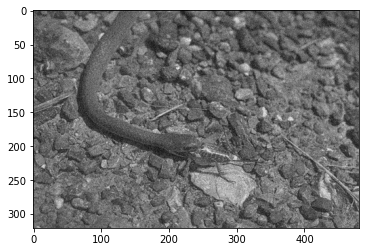

In [47]:
plt.imshow((x_test+y_test)[0],cmap='gray')